In [233]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
pd.options.display.max_columns = 170

In [234]:
import scipy.stats as stat
import statsmodels.stats.multicomp as mc
from scipy.stats import chisquare
from scipy.special import boxcox, inv_boxcox

In [332]:
from numpy import asarray
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.graphics.regressionplots import plot_regress_exog
from sklearn.model_selection import train_test_split
from statsmodels.discrete.discrete_model import Logit
from scipy.special import logit

In [236]:
data = pd.read_csv('BankChurners.csv')
data.head()

,CLIENTNUM,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1,Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2
0,768805383,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,0.000093,0.99991
1,818770008,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,0.000057,0.99994
2,713982108,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000,0.000021,0.99998
3,769911858,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760,0.000134,0.99987
4,709106358,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000,0.000022,0.99998


In [237]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 23 columns):
 #   Column                                                                                                                              Non-Null Count  Dtype  
---  ------                                                                                                                              --------------  -----  
 0   CLIENTNUM                                                                                                                           10127 non-null  int64  
 1   Attrition_Flag                                                                                                                      10127 non-null  object 
 2   Customer_Age                                                                                                                        10127 non-null  int64  
 3   Gender                                                                           

In [238]:
data.CLIENTNUM.nunique()
# no duplicates

10127

### Data Preparation
#### Removing non-contributory columns

In [239]:
for key in data.keys():
    if len(data[key].unique()) ==1:
        data.drop(key, axis = 1, inplace=True)
        print('dropped: ', key)
else:    
        print('Columns contain more than 1 unique values')

Columns contain more than 1 unique values


In [240]:
remove = ['CLIENTNUM', 
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
        'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2' ]
for x in remove:
    data.drop(x, axis = 1, inplace=True)

In [241]:
#data.head(2)

In [242]:
data.rename(columns = {'Attrition_Flag':  'Attrition',
                      'Customer_Age': 'Age',
                      'Dependent_count':'Dependents',
                      'Education_Level': 'Education',
                      'Marital_Status': 'Marital',
                      'Income_Category':'Income',
                      'Card_Category':'Card',
                      'Months_on_book':'Duration',
                      'Total_Relationship_Count':'Num_products',
                      'Months_Inactive_12_mon': 'Inactive_mo',
                      'Contacts_Count_12_mon': 'Contacts',
                      'Total_Revolving_Bal':'Revolving_Bal',
                      'Avg_Open_To_Buy': 'Avg_Open',
                      'Total_Amt_Chng_Q4_Q1': 'Amount_chg',
                      'Total_Trans_Amt': 'Transaction_amt',
                      'Total_Trans_Ct': 'Transaction_ct',
                      'Total_Ct_Chng_Q4_Q1':'Trans_Chg_ct',
                      'Avg_Utilization_Ratio':'Util_ratio'}, inplace=True)
#data.head(2)

#### Addressing missing/ unknown data

In [243]:
data.isnull().sum()

Attrition          0
Age                0
Gender             0
Dependents         0
Education          0
Marital            0
Income             0
Card               0
Duration           0
Num_products       0
Inactive_mo        0
Contacts           0
Credit_Limit       0
Revolving_Bal      0
Avg_Open           0
Amount_chg         0
Transaction_amt    0
Transaction_ct     0
Trans_Chg_ct       0
Util_ratio         0
dtype: int64

In [244]:
data.isin(['Unknown']).sum()

Attrition             0
Age                   0
Gender                0
Dependents            0
Education          1519
Marital             749
Income             1112
Card                  0
Duration              0
Num_products          0
Inactive_mo           0
Contacts              0
Credit_Limit          0
Revolving_Bal         0
Avg_Open              0
Amount_chg            0
Transaction_amt       0
Transaction_ct        0
Trans_Chg_ct          0
Util_ratio            0
dtype: int64

In [245]:
data.Education.replace({'Unknown': np.nan}, inplace=True)
data.Education.value_counts()

Graduate         3128
High School      2013
Uneducated       1487
College          1013
Post-Graduate     516
Doctorate         451
Name: Education, dtype: int64

In [246]:
# education grouped with gender, martial, income, shows
# consistent predominance of Graduate (code not shown here)

data.Education.fillna('Graduate', inplace=True)

# merge post grad data to reduce unnecessary granularity
data.Education.replace({'Doctorate':'Post-Graduate'}, inplace=True)
data.Education.value_counts()

Graduate         4647
High School      2013
Uneducated       1487
College          1013
Post-Graduate     967
Name: Education, dtype: int64

In [247]:
data.Marital.value_counts()

Married     4687
Single      3943
Unknown      749
Divorced     748
Name: Marital, dtype: int64

In [248]:
# replace unknown with mode Married
data.Marital.replace({'Unknown': 'Married'}, inplace=True)

In [249]:
data.Income.value_counts()

Less than $40K    3561
$40K - $60K       1790
$80K - $120K      1535
$60K - $80K       1402
Unknown           1112
$120K +            727
Name: Income, dtype: int64

In [250]:
# replace unknown with mode
# replace range with median value
data.Income.replace({'Unknown': '$40K',
                     'Less than $40K': '$40K',
             '$40K - $60K':'$50K',
             '$60K - $80K': '$70K',
            '$80K - $120K': '$100K',
            '$120K +': '$120K'},
            inplace=True)

#### Checking for incongruous labels among categorical variables

In [251]:
for key in data.select_dtypes('object').keys():
    print(key, ':', data[key].unique())

Attrition : ['Existing Customer' 'Attrited Customer']
Gender : ['M' 'F']
Education : ['High School' 'Graduate' 'Uneducated' 'College' 'Post-Graduate']
Marital : ['Married' 'Single' 'Divorced']
Income : ['$70K' '$40K' '$100K' '$50K' '$120K']
Card : ['Blue' 'Gold' 'Silver' 'Platinum']


#### Checking for incongruous data among continuous variables

In [252]:
data.describe()

,Age,Dependents,Duration,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Avg_Open,Amount_chg,Transaction_amt,Transaction_ct,Trans_Chg_ct,Util_ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


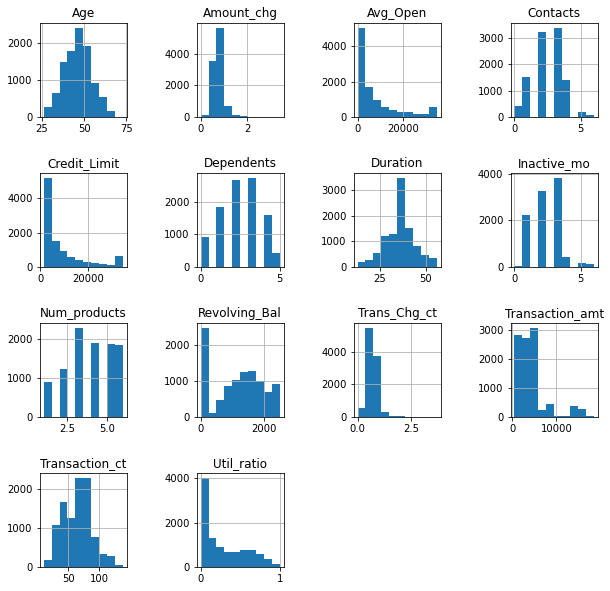

In [253]:
# checking distribution among numerical variables
data.hist(figsize = (10,10))
plt.subplots_adjust(hspace = 0.6, wspace = 0.8);

In [254]:
# normal distribution for age, amount_chg, contacts, depedents,
#   duration, num_products, transaction_chg_ct, transaction_ct
# skewed distribution for avg_open, credit limit, inactive mo,
#     revolving bal, transaction amt, util ratio

#### Cleaned data for Exploratory Analysis

In [255]:
data.head()
# value names maintained for now to facilitate labeling

,Attrition,Age,Gender,Dependents,Education,Marital,Income,Card,Duration,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Avg_Open,Amount_chg,Transaction_amt,Transaction_ct,Trans_Chg_ct,Util_ratio
0,Existing Customer,45,M,3,High School,Married,$70K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,$40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$100K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Married,$40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$70K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


Note:  (Usual univariate and bivariate exploration deferred, in anticipation that other members of the group will likely perform it.)

### Statement of Hypotheses

#### Scenario:  Being hired by a bank to determine:
A.  The profile of its credit card users
        
        Null hypotheses:
            1.  There is no difference in distribution between male and female customers,
            2.  There is no relationship between age and income among the customers,
            3.  There is no relationship between marital status and income among the customers,
            4.  There is no association between education and income among the customers.
            
B.  The most popular credit cards type
        
        Null hypotheses;
            1.  There is no difference in the distribution between the different card types,
            2.  Card type is independent of the customers'
                    a.  age,
                    b.  gender,
                    c.  education,
                    d.  marital status,
                    e.  income
                    
C.  Factors associated with high use of credit funds among users
        
        Null hypotheses:
            1.  There is no difference in the amount and number of transaction between genders,
            2.  There is no difference in the number of transactions between different card types,
            3.  There is no relationship between credit limit and utilization ratio
            
D.  Predict which users are likely to stay as customers instead of churning
        
        Null hypotheses:
            1.  The outcome of attrition is not affected by any of the base attributes in the dataset, and thus cannot be predicted.
    
    

### Targeted Analyses 

#### Hypothesis A.1.  There is no difference in distribution between male and female customers

,Gender
F,5358
M,4769


p val=  [0.]


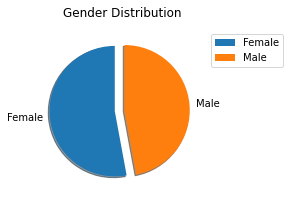

In [256]:
# assumption: expected equal frequencies
obs = pd.DataFrame(data.Gender.value_counts())
st, p = chisquare(obs)
display(obs)
print('p val= ', p.round(4))
exp = (data.Gender.count()) /2

plt.figure(figsize = (3,3))
plt.pie(obs, explode = (0.15, 0), shadow = True, startangle = 90,
       labels = ['Female','Male'])
plt.suptitle('Gender Distribution')
plt.legend(bbox_to_anchor=(1,1));

Result:  At p < 0.01, the null hypotheses is rejected.

Interpretation:  There is a significantly higher proportion of females among the customers.

#### Hypothesis A.2.   There is no relationship between age and income level among the customers

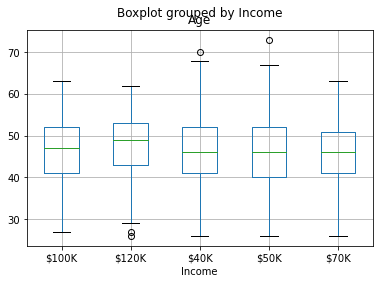

In [257]:
data.boxplot('Age', by='Income');

In [258]:
data.groupby('Income')['Age'].describe()

,count,mean,std,min,25%,50%,75%,max
Income,,,,,,,,
$100K,1535.0,46.428013,6.857736,27.0,41.0,47.0,52.0,63.0
$120K,727.0,47.603851,6.769921,26.0,43.0,49.0,53.0,62.0
$40K,4673.0,46.292318,8.497843,26.0,41.0,46.0,52.0,70.0
$50K,1790.0,46.087151,8.434617,26.0,40.0,46.0,52.0,73.0
$70K,1402.0,45.968616,7.520167,26.0,41.0,46.0,51.0,63.0


In [259]:
# ANOVA conditions:
# 1.  observations are mostly independent
# 2.  data distribution is nearly normal
# 3.  variability across groups is comparable

In [260]:
# using ANOVA / f one way
inc = data.Income
age = data.Age
stat.f_oneway( age [ inc == '$40K'],
             age [ inc == '$50K'],
             age [ inc == '$70K'],
             age [ inc == '$100K'],
             age [ inc == '$120K'])
# p=0.0001 -> at least one group is different

F_onewayResult(statistic=5.805298780895835, pvalue=0.00011565813366589263)

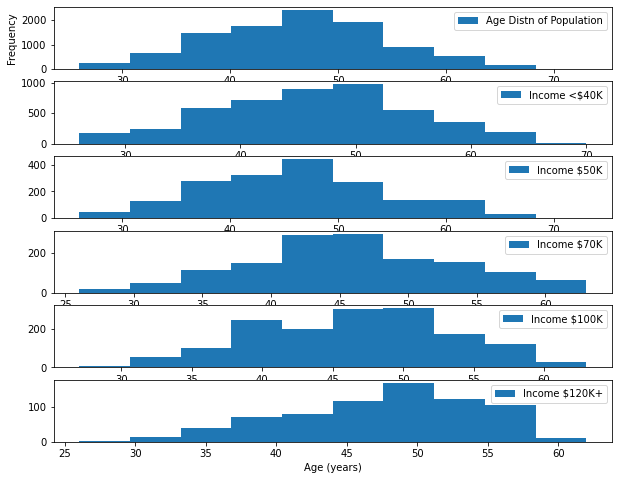

In [261]:
low = age [ inc == '$40K']
low_med =  age [ inc == '$50K']
med =   age [ inc == '$70K']
high_med =  age [ inc == '$100K']
high =  age [ inc == '$120K']

plt.figure(figsize = (10,8))
plt.subplot(611)
plt.hist(age, label = 'Age Distn of Population')
plt.ylabel('Frequency');
plt.legend()

plt.subplot(612)
plt.hist(low, label = 'Income <$40K')
plt.legend()

plt.subplot(613)
plt.hist(low_med, label = 'Income $50K')
plt.legend()

plt.subplot(614)
plt.hist(med, label = 'Income $70K')
plt.legend()

plt.subplot(615)
plt.hist(high_med, label = 'Income $100K')
plt.legend()

plt.subplot(616)
plt.hist(high, label = 'Income $120K+')
plt.xlabel('Age (years)')
plt.legend();

In [262]:
comp = mc.MultiComparison(data['Age'], data['Income'])
table, arr1, arr2 = comp.allpairtest(stat.ttest_ind, method = 'bonf')
table

group1,group2,stat,pval,pval_corr,reject
$100K,$120K,-3.8241,0.0001,0.0013,True
$100K,$40K,0.5678,0.5702,1.0,False
$100K,$50K,1.2649,0.206,1.0,False
$100K,$70K,1.7316,0.0835,0.8345,False
$120K,$40K,3.9699,0.0001,0.0007,True
$120K,$50K,4.3164,0.0,0.0002,True
$120K,$70K,4.9196,0.0,0.0,True
$40K,$50K,0.8704,0.3841,1.0,False
$40K,$70K,1.2835,0.1994,1.0,False
$50K,$70K,0.4131,0.6796,1.0,False


In [263]:
# difference:
# <40, 50, 70, 100 versus 120+

Result: At p = <0.01, the null Ho is rejected.  The age distribution of customers who are earning $120+ is different from the rest of the income groups.  

Interpretation:  Those earning $120+ are older, with a mean age of 47.6 +/- 6.7 (CI 43-53).

#### Hypothesis A.3.  There is no relationship between marital status and income among the customers

In [264]:
# assumption: normal distribution
df= pd.crosstab(data.Income, data.Marital)
#display(df)
x2, p, dof, exp = stat.chi2_contingency(df)
# getting normalized values
print('Percentage Distribution between Marital Status and Income Levels')
df1= pd.crosstab(data.Income, data.Marital, normalize=True, margins=True)
df1 = df1.reindex(['$40K','$50K','$70K','$100K','$120K'])
df1 = df1.reindex(columns = ['Single','Married','Divorced'])
display((df1*100).round(2))

print('chi2_contingency pval = ', p.round(4))
st, p = chisquare(df, axis = 0)
print('chisquare axis 0 pval = ', p.round(4))
st, p = chisquare(df, axis = 1)
print('chisquare axis 1 pval = ', p.round(4))

# chisquare applied prior to normalization

Percentage Distribution between Marital Status and Income Levels


Marital,Single,Married,Divorced
Income,,,
$40K,18.50,24.22,3.43
$50K,6.95,9.36,1.36
$70K,5.24,7.53,1.07
$100K,5.54,8.60,1.02
$120K,2.71,3.96,0.51


chi2_contingency pval =  0.2273
chisquare axis 0 pval =  [0. 0. 0.]
chisquare axis 1 pval =  [0. 0. 0. 0. 0.]


Results:  The values between Marital levels are significantly different.  The values between Income levels are significantly different.  However, at p > 0.05, there is a failure to reject the hypothesis.

Interpretation:  Income level is independent of marital status.

#### Hypothesis A.4.  There is no association between education and income among the customers

In [265]:
# assumption: normal distribution
df= pd.crosstab(data.Income, data.Education)
#display(df)
x2, p, dof, exp = stat.chi2_contingency(df)
# getting normalized values
df1= pd.crosstab(data.Income, data.Education, normalize=True, margins=True)
df1 = df1.reindex(['$40K','$50K','$70K','$100K','$120K'])
df1 = df1.reindex(columns = ['Uneducated','High School','College','Graduate','Post-Graduate'])
print('Percentage Distribution between Education and Income Levels')
display((df1*100).round(2))

print('chi2_contingency pval = ', p.round(4))
st, p = chisquare(df, axis = 0)
print('chisquare axis 0 pval = ', p.round(4))
st, p = chisquare(df, axis = 1)
print('chisquare axis 1 pval = ', p.round(4))

# chisquare applied prior to normalization

Percentage Distribution between Education and Income Levels


Education,Uneducated,High School,College,Graduate,Post-Graduate
Income,,,,,
$40K,6.98,8.85,4.47,21.45,4.39
$50K,2.46,3.51,1.81,8.12,1.79
$70K,1.93,3.03,1.30,6.24,1.34
$100K,2.14,3.04,1.73,6.88,1.36
$120K,1.18,1.45,0.69,3.20,0.66


chi2_contingency pval =  0.5979
chisquare axis 0 pval =  [0. 0. 0. 0. 0.]
chisquare axis 1 pval =  [0. 0. 0. 0. 0.]


Results:  The values between Educational levels are significantly different.  The values between Income levels are significantly different.  However, at p > 0.05, there is a failure to reject the hypothesis.

Interpretation:  Income is independent of educational level.

#### Hypothesis B.1.  There is no difference in the distribution between the different card types

,Card
Blue,9436
Silver,555
Gold,116
Platinum,20


p value =  0.0


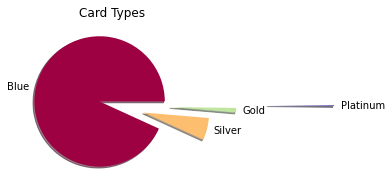

In [266]:
card = data.Card.value_counts()
display(pd.DataFrame(card))
st, p = chisquare(card)
print('p value = ', p.round(4))

card.plot(kind = 'pie', explode = (0.2, 0.5, 0.9, 2.4),
          figsize = (3,3), cmap='Spectral',
         shadow=True)
plt.title('Card Types')
plt.ylabel(None);

Result:  At p < 0.01, the null hypothesis is rejected.

Intepretation:  The proportions of the card types are significantly different, with Blue predominating, followed by Silver, Gold, and Platinum the least common.

#### Hypothesis B.2.a.  The card type is independent of the customers' age

In [267]:
# grouping into age groups
labels = ['young','middle','older']
bins = [20, 40, 60, 80]
data['Age_group']  = pd.cut(data.Age, bins=bins, labels = labels, right=True )
data.Age_group.value_counts()

middle    7325
young     2397
older      405
Name: Age_group, dtype: int64

Percentage Distribution between Age group and Card type


Card,Blue,Silver,Gold,Platinum
Age_group,,,,
young,22.18,1.23,0.25,0.01
middle,67.16,4.11,0.88,0.19
older,3.84,0.14,0.02,0.00
All,93.18,5.48,1.15,0.20


chi2_contingency pval =  0.0722
chisquare axis 0 pval =  [0. 0. 0. 0.]
chisquare axis 1 pval =  [0. 0. 0.]


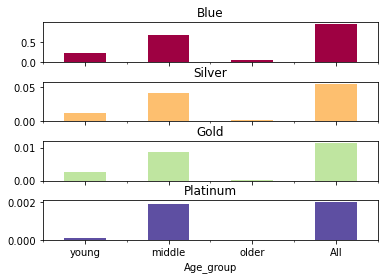

In [268]:
# assumption: normal distribution
df= pd.crosstab(data.Age_group, data.Card)
#display(df)
x2, p, dof, exp = stat.chi2_contingency(df)
# getting normalized values
df1= pd.crosstab(data.Age_group, data.Card, normalize=True, margins=True)
df1 = df1.reindex(columns = ['Blue','Silver','Gold','Platinum'])
print('Percentage Distribution between Age group and Card type')
display((df1*100).round(2))

print('chi2_contingency pval = ', p.round(4))
st, p = chisquare(df, axis = 0)
print('chisquare axis 0 pval = ', p.round(4))
st, p = chisquare(df, axis = 1)
print('chisquare axis 1 pval = ', p.round(4))

df1.plot(kind='bar', subplots=True, colormap = 'Spectral',
         legend=None, rot=0)
plt.subplots_adjust(hspace = 0.5);
# chisquare applied prior to normalization

Result: There is a significant difference in the distribution proportion of Age groups that use different card types.  However, at p > 0.05, there is failure to reject the null hypothesis.

Interpretation:  The card type held by the customer is independent of his/her age group.

#### Hypothesis B.2.b.  The card type is independent of the customers' gender

Percentage Distribution between Genders and Card type


Card,Blue,Silver,Gold,Platinum
Gender,,,,
F,50.37,2.07,0.38,0.09
M,42.81,3.41,0.77,0.11
All,93.18,5.48,1.15,0.20


chi2_contingency pval =  0.0
chisquare axis 0 pval =  [0.000e+00 2.000e-04 6.547e-01 0.000e+00]
chisquare axis 1 pval =  [0. 0.]


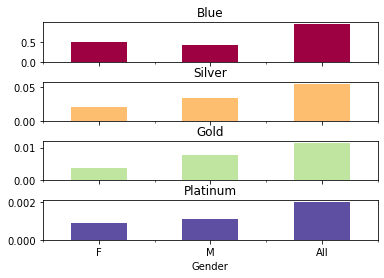

In [269]:
# assumption: normal distribution
df= pd.crosstab(data.Gender, data.Card)
#display(df)
x2, p, dof, exp = stat.chi2_contingency(df)
# getting normalized values
df1= pd.crosstab(data.Gender, data.Card, normalize=True, margins=True)
df1 = df1.reindex(columns = ['Blue','Silver','Gold','Platinum'])
print('Percentage Distribution between Genders and Card type')
display((df1*100).round(2))

print('chi2_contingency pval = ', p.round(4))
st, p = chisquare(df, axis = 0)
print('chisquare axis 0 pval = ', p.round(4))
st, p = chisquare(df, axis = 1)
print('chisquare axis 1 pval = ', p.round(4))

df1.plot(kind='bar', subplots=True, colormap = 'Spectral',
         legend=None, rot=0)
plt.subplots_adjust(hspace = 0.5);
# chisquare applied prior to normalization

In [270]:
dummies = pd.get_dummies(data.Card)
for dum in dummies:
    dfa = pd.crosstab(dummies[f'{dum}'], data.Gender)
    x2, p, dof, exp = stat.chi2_contingency(dfa)
    dfb = pd.crosstab(dummies[f'{dum}'], data.Gender, normalize=True)
    display((dfb*100).round(2))
    print(f'pval = {p.round(4)}')

Gender,F,M
Blue,,
0,2.54,4.29
1,50.37,42.81


pval = 0.0


Gender,F,M
Gold,,
0,52.53,46.32
1,0.38,0.77


pval = 0.0


Gender,F,M
Platinum,,
0,52.82,46.98
1,0.09,0.11


pval = 0.6277


Gender,F,M
Silver,,
0,50.83,43.69
1,2.07,3.41


pval = 0.0


Result:  At p < 0.01, the null hypothesis was rejected.  Further dissection of the data revealed significant differences in the distribution of genders among the different card types.

Interpretation: There is a significantly higher proportion of female Blue card holders compared to males.  There are more male Silver- and Gold- cardholders.  The gender proportion is equal among Platinum-card holders.

#### Hypothesis B.2.c.  The card type is independent of the customers' educational attainment

In [271]:
# assumption: normal distribution
df= pd.crosstab(data.Education, data.Card)
#display(df)
x2, p, dof, exp = stat.chi2_contingency(df)
# getting normalized values
df1= pd.crosstab(data.Education, data.Card, normalize=True, margins=True)
df1 = df1.reindex(['Uneducated','High School','College','Graduate','Post-Graduate'])
df1 = df1.reindex(columns = ['Blue','Silver','Gold','Platinum'])
print('Percentage Distribution between Education level and Card type')
display((df1*100).round(2))

print('chi2_contingency pval = ', p.round(4))
st, p = chisquare(df, axis = 0)
print('chisquare axis 0 pval = ', p.round(4))
st, p = chisquare(df, axis = 1)
print('chisquare axis 1 pval = ', p.round(4))

# chisquare applied prior to normalization

Percentage Distribution between Education level and Card type


Card,Blue,Silver,Gold,Platinum
Education,,,,
Uneducated,13.74,0.81,0.11,0.03
High School,18.64,0.97,0.26,0.01
College,9.28,0.57,0.15,0.00
Graduate,42.65,2.60,0.53,0.11
Post-Graduate,8.87,0.53,0.10,0.05


chi2_contingency pval =  0.2333
chisquare axis 0 pval =  [0.     0.     0.0008 0.    ]
chisquare axis 1 pval =  [0. 0. 0. 0. 0.]


Result:  At p > 0.05, there is failure to reject the null hypothesis.

Interpretation:  Card type is independent of educational attainment.

#### Hypothesis B.2.d.  The card type is independent of the customers' marital status

Percentage Distribution between Marital status and Card type


Card,Blue,Silver,Gold,Platinum
Marital,,,,
Single,35.79,2.48,0.57,0.10
Married,50.52,2.55,0.52,0.09
Divorced,6.87,0.45,0.05,0.01


chi2_contingency pval =  0.0024


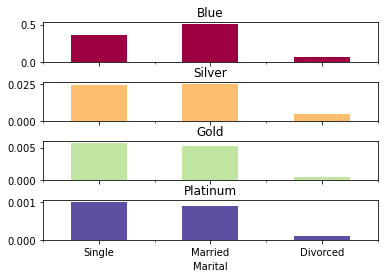

In [272]:
# assumption: normal distribution
df= pd.crosstab(data.Marital, data.Card)
#display(df)
x2, p, dof, exp = stat.chi2_contingency(df)
# getting normalized values
df1= pd.crosstab(data.Marital, data.Card, normalize=True, margins=True)
df1 = df1.reindex(['Single','Married','Divorced'])
df1 = df1.reindex(columns = ['Blue','Silver','Gold','Platinum'])
print('Percentage Distribution between Marital status and Card type')
display((df1*100).round(2))

print('chi2_contingency pval = ', p.round(4))

df1.plot(kind='bar', subplots=True, colormap = 'Spectral',
         legend=None, rot=0)
plt.subplots_adjust(hspace = 0.5);

# chisquare applied prior to normalization

In [273]:
dummies = pd.get_dummies(data.Marital)
for dum in dummies:
    dfa = pd.crosstab(dummies[f'{dum}'], data.Card)
    x2, p, dof, exp = stat.chi2_contingency(dfa)
    dfb = pd.crosstab(dummies[f'{dum}'], data.Card, normalize=True)
    #display(dfa)
    display((dfb*100).round(2))
    print(f'pval = {p.round(4)}')

Card,Blue,Gold,Platinum,Silver
Divorced,,,,
0,86.30,1.10,0.19,5.03
1,6.87,0.05,0.01,0.45


pval = 0.4876


Card,Blue,Gold,Platinum,Silver
Married,,,,
0,42.66,0.62,0.11,2.93
1,50.52,0.52,0.09,2.55


pval = 0.001


Card,Blue,Gold,Platinum,Silver
Single,,,,
0,57.39,0.57,0.1,3.00
1,35.79,0.57,0.1,2.48


pval = 0.0006


In [274]:
dummies = pd.get_dummies(data.Card)
for dum in dummies:
    dfa = pd.crosstab(dummies[f'{dum}'], data.Marital)
    x2, p, dof, exp = stat.chi2_contingency(dfa)
    dfb = pd.crosstab(dummies[f'{dum}'], data.Marital, normalize=True)
    #display(dfa)
    display((dfb*100).round(2))
    print(f'pval = {p.round(4)}')

Marital,Divorced,Married,Single
Blue,,,
0,0.51,3.16,3.15
1,6.87,50.52,35.79


pval = 0.0002


Marital,Divorced,Married,Single
Gold,,,
0,7.34,53.15,38.36
1,0.05,0.52,0.57


pval = 0.0371


Marital,Divorced,Married,Single
Platinum,,,
0,7.38,53.59,38.84
1,0.01,0.09,0.10


pval = 0.5869


Marital,Divorced,Married,Single
Silver,,,
0,6.93,51.13,36.46
1,0.45,2.55,2.48


pval = 0.0022


Result:  At p < 0.01, the null hypothesis is rejected.  There are relationships between card types and marital status.

Interpretation:  The Blue cards are predominantly used by all the kinds of marital statuses, but is especially associated with the married status.  

#### Hypothesis B.2.e.  The card type is independent of the customers' income level

Percentage Distribution between Income Level and Card type


Card,Blue,Silver,Gold,Platinum
Income,,,,
$40K,43.92,1.81,0.33,0.09
$50K,16.54,0.98,0.15,0.01
$70K,12.57,0.95,0.29,0.04
$100K,13.78,1.16,0.21,0.02
$120K,6.37,0.59,0.18,0.04


chi2_contingency pval =  0.0


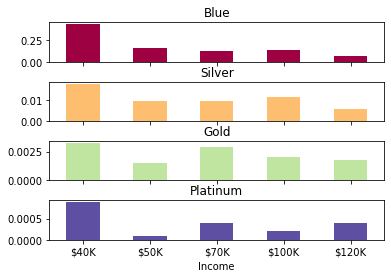

In [275]:
# assumption: normal distribution
df= pd.crosstab(data.Income, data.Card)
#display(df)
x2, p, dof, exp = stat.chi2_contingency(df)
# getting normalized values
df1= pd.crosstab(data.Income, data.Card, normalize=True, margins=True)
df1 = df1.reindex(['$40K','$50K','$70K','$100K','$120K'])
df1 = df1.reindex(columns = ['Blue','Silver','Gold','Platinum'])
print('Percentage Distribution between Income Level and Card type')
display((df1*100).round(2))

print('chi2_contingency pval = ', p.round(4))

df1.plot(kind='bar', subplots=True, colormap = 'Spectral',
         legend=None, rot=0)
plt.subplots_adjust(hspace = 0.5);

# chisquare applied prior to normalization

In [276]:
dummies = pd.get_dummies(data.Card)
for dum in dummies:
    dfa = pd.crosstab(dummies[f'{dum}'], data.Income)
    x2, p, dof, exp = stat.chi2_contingency(dfa)
    dfb = pd.crosstab(dummies[f'{dum}'], data.Income, normalize=True)
    #display(dfa)
    display((dfb*100).round(2))
    print(f'pval = {p.round(4)}')

Income,$100K,$120K,$40K,$50K,$70K
Blue,,,,,
0,1.38,0.81,2.22,1.14,1.27
1,13.78,6.37,43.92,16.54,12.57


pval = 0.0


Income,$100K,$120K,$40K,$50K,$70K
Gold,,,,,
0,14.95,7.00,45.82,17.53,13.56
1,0.21,0.18,0.33,0.15,0.29


pval = 0.0


Income,$100K,$120K,$40K,$50K,$70K
Platinum,,,,,
0,15.14,7.14,46.06,17.67,13.80
1,0.02,0.04,0.09,0.01,0.04


pval = 0.1201


Income,$100K,$120K,$40K,$50K,$70K
Silver,,,,,
0,14.00,6.59,44.34,16.70,12.90
1,1.16,0.59,1.81,0.98,0.95


pval = 0.0


Results:  At p < 0.01, there are associations between card type and income level.

Interpretation:  A significant number of customers use the Blue card more than the other types of cards, especially those of the lower-income level.

#### Hypothesis C.1  There is no difference in the amount and number of transactions between genders

Mean Tr amt fem 4324.0
Mean Tr amt male 4494.0
p value =  0.0123


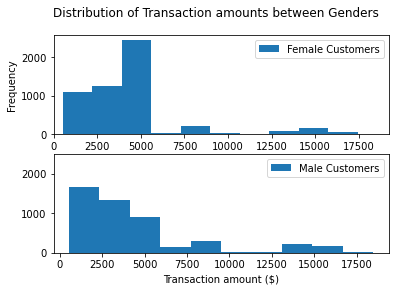

In [277]:
# using 2-sample t-test
fem_amount = data [ data['Gender'] == 'F'] ['Transaction_amt']
male_amount = data [ data['Gender'] == 'M'] ['Transaction_amt']
st, p = stat.ttest_ind(fem_amount, male_amount)
print('Mean Tr amt fem', round(fem_amount.mean(), 0))
print('Mean Tr amt male', round(male_amount.mean(),0))
print('p value = ', p.round(4))

#plt.figure(figsize = (10,8))
plt.subplot(211)
plt.hist(fem_amount, label = 'Female Customers')
plt.ylabel('Frequency');
plt.legend()
plt.xlim(0, 19200)

plt.subplot(212)
plt.hist(male_amount, label = 'Male Customers')
plt.ylim(0,2500)   
plt.legend()
plt.xlabel('Transaction amount ($)')
plt.suptitle('Distribution of Transaction amounts between Genders');

Mean Tr ct fem 66.0
Mean Tr ct male 63.0
p value =  0.0


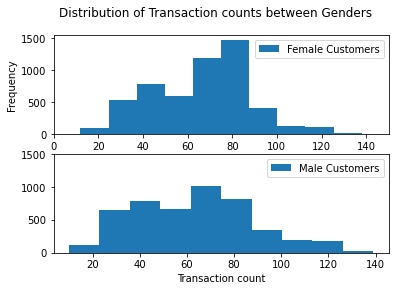

In [278]:
# using 2-sample t-test
fem_ct = data [ data['Gender'] == 'F'] ['Transaction_ct']
male_ct = data [ data['Gender'] == 'M'] ['Transaction_ct']
st, p = stat.ttest_ind(fem_ct, male_ct)
print('Mean Tr ct fem', round(fem_ct.mean(), 0))
print('Mean Tr ct male', round(male_ct.mean(),0))
print('p value = ', p.round(4))

plt.subplot(211)
plt.hist(fem_ct, label = 'Female Customers')
plt.ylabel('Frequency');
plt.legend()
plt.xlim(0, 150)

plt.subplot(212)
plt.hist(male_ct, label = 'Male Customers')
plt.ylim(0,1500)   
plt.legend()
plt.xlabel('Transaction count')
plt.suptitle('Distribution of Transaction counts between Genders');

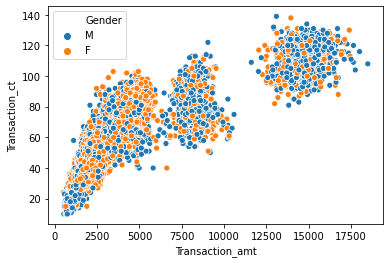

In [279]:
sns.scatterplot(x = data.Transaction_amt, y = data.Transaction_ct,hue=data.Gender);

Result: At a p < 0.05, the null hypothesis is rejected.  There is a difference in transaction amounts and transaction counts between genders.

Interpretation:  Female customers make more frequent transactions.  Male customers make more expensive transactions.

#### Hypothesis C.2.   There is no difference in the number of transsactions between different card types

In [280]:
# ANOVA conditions:
# 1.  observations are mostly independent
# 2.  data distribution is nearly normal
# 3.  variability across groups is comparable

p value =  0.0


''

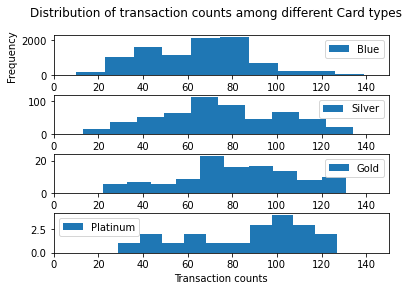

In [281]:
# using ANOVA / f one way
t_ct = data.Transaction_ct
card = data.Card
blue= t_ct [ card == 'Blue']
silver =t_ct [ card == 'Silver']
gold= t_ct [ card == 'Gold']
platinum= t_ct [ card == 'Platinum']

st,p = stat.f_oneway(blue, silver, gold, platinum)
print('p value = ', p.round(4))

plt.subplot(411)
plt.hist(blue, label = 'Blue')
plt.ylabel('Frequency');
plt.legend()
plt.xlim(0,150);

plt.subplot(412)
plt.hist(silver, label = 'Silver')
plt.legend()
plt.xlim(0,150);

plt.subplot(413)
plt.hist(gold, label = 'Gold')
plt.legend()
plt.xlim(0,150);

plt.subplot(414)
plt.hist(platinum, label = 'Platinum')
plt.legend()
plt.xlabel('Transaction counts')
plt.xlim(0,150)

plt.suptitle('Distribution of transaction counts among different Card types')
plt.subplots_adjust(hspace = 0.5)
## ylim not adjusted
;

Results:  At p <0.01, the null hypothesis is rejected.  At least one of the card types have a different distribution for the transaction count.

Interpretation:  Platinum card holders make more frequent transactions.

#### Hypothesis C.3.  There is no relationship between credit limit and utilization ratio

Intercept    0.401351
X           -0.000015
dtype: float64

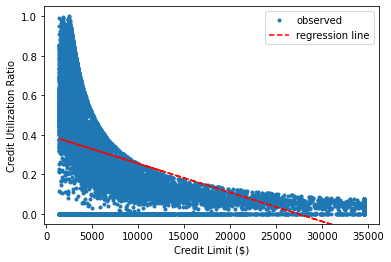

In [282]:
X = data.Credit_Limit
y = data.Util_ratio
model = smf.ols('y ~ X', data).fit()
intercept, slope = model.params
display(model.params)

util_pred = intercept + slope *X

plt.plot(X, y, '.',
        label = 'observed')
plt.plot(X, util_pred, 'r-', label = 'regression line', linestyle = '--')
plt.xlabel('Credit Limit ($)')
plt.ylabel('Credit Utilization Ratio')
plt.ylim(-0.05, 1.05)
plt.legend();

In [283]:
# transforming x
x_arr = np.array(data.Credit_Limit)
x_box = stat.boxcox(x_arr)
print('x lambda: ', x_box[1])
x_transf = np.split(x_box[0],10127, axis=0)
x_transf_ = pd.DataFrame(x_transf)
## transforming y did not result in a better distribution

x lambda:  -0.2874551354648639


Intercept    6.269964
x_transf    -1.888094
dtype: float64

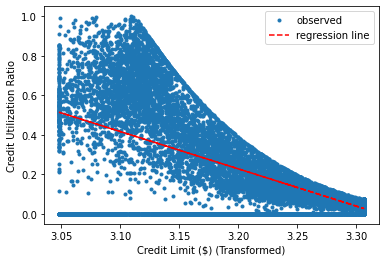

In [284]:
# model using transformed x values
y = data.Util_ratio
model = smf.ols('y ~ x_transf', data).fit()
intercept, slope = model.params
display(model.params)

util_pred = intercept + slope * x_transf_

plt.plot(x_transf, y, '.',
        label = 'observed')
plt.plot(x_transf_, util_pred, 'r-', label = 'regression line', linestyle = '--')
plt.xlabel('Credit Limit ($) (Transformed)')
plt.ylabel('Credit Utilization Ratio')
plt.ylim(-0.05, 1.05)
plt.legend();

In [285]:
# predicting y values using x_transformed data
data['Util_model_pred'] = model.predict()

# y_model = 6.3 - 1.9(x_transf)
data['Credit_Limit_transf']= x_transf
data['Util_comp_pred'] = 6.3 - (1.9 * data.Credit_Limit_transf)
data.head(2)

,Attrition,Age,Gender,Dependents,Education,Marital,Income,Card,Duration,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Avg_Open,Amount_chg,Transaction_amt,Transaction_ct,Trans_Chg_ct,Util_ratio,Age_group,Util_model_pred,Credit_Limit_transf,Util_comp_pred
0,Existing Customer,45,M,3,High School,Married,$70K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061,middle,0.136049,[3.24873427815878],[0.12740487149831825]
1,Existing Customer,49,F,5,Graduate,Single,$40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105,middle,0.193195,[3.2184676547573843],[0.18491145596096992]


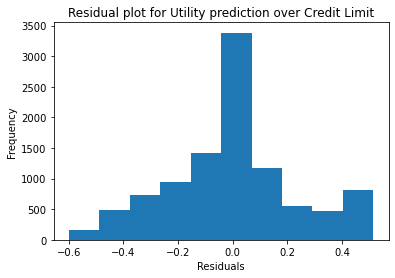

In [286]:
# checking for residuals in the predicted values
data['Util_res'] = data.Util_model_pred - data.Util_ratio
plt.hist(data.Util_res)
plt.title('Residual plot for Utility prediction over Credit Limit')
plt.xlabel('Residuals')
plt.ylabel('Frequency');
# normal distribution, close to 0

Result:
The Distribution was highly skewed.  Transformation provided  some improvement.  The slope was consistently negative.  Modelling using transformed Credit Limit data, revealed that Utility ratio can be modelled using the equation 6.3 - 1.9(Credit limit).

Interpretation:
Credits up to 4 thousand dollars are well utilized.  Beyond 4 thousand, there is a sharp decline in credit utilization.

#### Hypothesis D.1.  The outcome of attrition is not affected by any of the base attributes in the dataset, and thus cannot be predicted

In [287]:
#  Assumptions:
#  samples are independent
#  no expected cell count = 0
#  no more than 20% of cells have expected count <5

(Select codes shown to simplify)
Not significant:  Age

Mean product use of Attrited Customers:  3.28
Mean product use of Existing Customers:  3.91
p value =  0.0


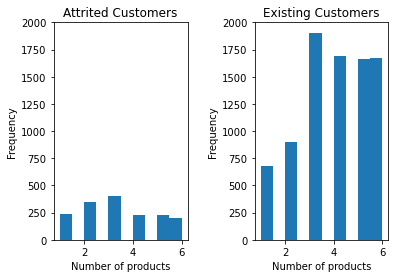

In [288]:
att = data[data.Attrition == 'Attrited Customer']['Num_products']
ret = data[data.Attrition == 'Existing Customer']['Num_products']

plt.subplot(121)
att.plot.hist()
plt.xlabel('Number of products')
plt.title('Attrited Customers')
plt.ylim(0, 2000);

plt.subplot(122)
ret.plot.hist()
plt.xlabel('Number of products')
plt.title('Existing Customers')
plt.subplots_adjust(wspace = 0.5);

st, p = stat.ttest_ind(att, ret)
print('Mean product use of Attrited Customers: ',round(att.mean(),2))
print('Mean product use of Existing Customers: ',round(ret.mean(),2))
print('p value = ', p.round(4))

Result:  At p < 0.01, null hypothesis is rejected.

Interpretation:  Attrited customers used less products compared to existing customers.

Mean number of contacts from Attrited Customers:  2.97
Mean number of contacts from Existing Customers:  2.36
p value =  0.0


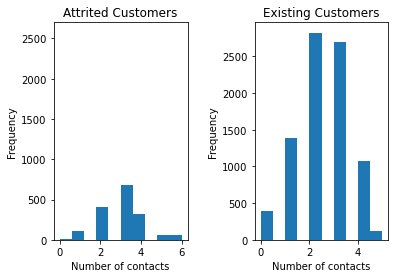

In [289]:
att = data[data.Attrition == 'Attrited Customer']['Contacts']
ret = data[data.Attrition == 'Existing Customer']['Contacts']

plt.subplot(121)
att.plot.hist()
plt.xlabel('Number of contacts')
plt.title('Attrited Customers')
plt.ylim(0, 2700);

plt.subplot(122)
ret.plot.hist()
plt.xlabel('Number of contacts')
plt.title('Existing Customers')
plt.subplots_adjust(wspace = 0.5);

st, p = stat.ttest_ind(att, ret)
print('Mean number of contacts from Attrited Customers: ',round(att.mean(),2))
print('Mean number of contacts from Existing Customers: ',round(ret.mean(),2))
print('p value = ', p.round(4))

Interpretation:  Attrited customers had a higher number of contacts with the bank.

Mean credit limit of Attrited Customers:  8136.04
Mean credit limit of Existing Customers:  8726.88
p value =  0.0163


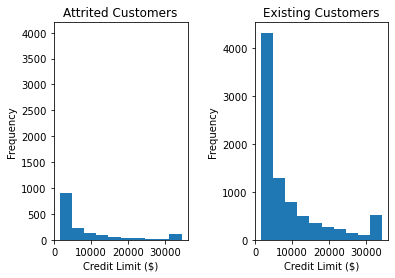

In [290]:
att = data[data.Attrition == 'Attrited Customer']['Credit_Limit']
ret = data[data.Attrition == 'Existing Customer']['Credit_Limit']

plt.subplot(121)
att.plot.hist()
plt.xlabel('Credit Limit ($)')
plt.title('Attrited Customers')
plt.ylim(0, 4200);

plt.subplot(122)
ret.plot.hist()
plt.xlabel('Credit Limit ($)')
plt.title('Existing Customers')
plt.subplots_adjust(wspace = 0.5);

st, p = stat.ttest_ind(att, ret)
print('Mean credit limit of Attrited Customers: ',round(att.mean(),2))
print('Mean credit limit of Existing Customers: ',round(ret.mean(),2))
print('p value = ', p.round(4))

Interpretation:  Attrited customers had a lower mean credit limit.

Mean Revolving Balance of Attrited Customers:  672.82
Mean Revolving Balance of Existing Customers:  1256.6
p value =  0.0


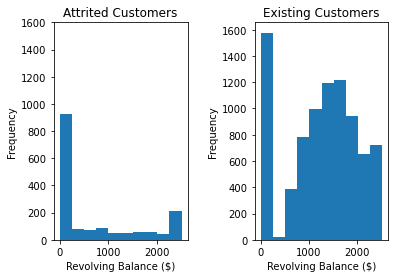

In [291]:
att = data[data.Attrition == 'Attrited Customer']['Revolving_Bal']
ret = data[data.Attrition == 'Existing Customer']['Revolving_Bal']

plt.subplot(121)
att.plot.hist()
plt.xlabel('Revolving Balance ($)')
plt.title('Attrited Customers')
plt.ylim(0, 1600);

plt.subplot(122)
ret.plot.hist()
plt.xlabel('Revolving Balance ($)')
plt.title('Existing Customers')
plt.subplots_adjust(wspace = 0.5);

st, p = stat.ttest_ind(att, ret)
print('Mean Revolving Balance of Attrited Customers: ',round(att.mean(),2))
print('Mean Revolving Balance of Existing Customers: ',round(ret.mean(),2))
print('p value = ', p.round(4))

Interpretation:  Attrited customers had lower revolving balance.

Mean Transaction counts of Attrited Customers:  44.93
Mean Transaction counts of Existing Customers:  68.67
p value =  0.0


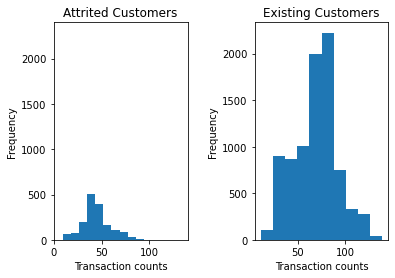

In [292]:
att = data[data.Attrition == 'Attrited Customer']['Transaction_ct']
ret = data[data.Attrition == 'Existing Customer']['Transaction_ct']

plt.subplot(121)
att.plot.hist()
plt.xlabel('Transaction counts')
plt.title('Attrited Customers')
plt.ylim(0, 2400)
plt.xlim(0, 140);

plt.subplot(122)
ret.plot.hist()
plt.xlabel('Transaction counts')
plt.title('Existing Customers')
plt.subplots_adjust(wspace = 0.5);

st, p = stat.ttest_ind(att, ret)
print('Mean Transaction counts of Attrited Customers: ',round(att.mean(),2))
print('Mean Transaction counts of Existing Customers: ',round(ret.mean(),2))
print('p value = ', p.round(4))

Interpretation:  Attrited customers had significantly less mean transaction counts

Failed to reject Null Hypotheses on Attrition and:
Dependents,

Questionable:  Inactive mo, trans chg ct
(Code not shown to simplify)

#### Preparing data for regression analyses and modeling (as continuation of analysis for Hypothesis D.1.)

##### Reducing correlation

In [293]:
data2= data
#data2.head(2)

In [294]:
def corr_map(variables):
    corr = data2[variables].corr().round(2)
    max_corr = 0.4
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)]=True
    with sns.axes_style('white'):
        f, ax = plt.subplots(figsize = (9,9))
        ax = sns.heatmap(corr, vmax = max_corr, mask = mask,
                        annot=True)

In [231]:
data2.columns

Index(['Attrition', 'Age', 'Gender', 'Dependents', 'Education', 'Marital',
       'Income', 'Card', 'Num_products', 'Inactive_mo', 'Contacts',
       'Credit_Limit', 'Revolving_Bal', 'Transaction_ct', 'Trans_Chg_ct',
       'Age_group', 'Util_model_pred', 'Credit_Limit_transf', 'Util_comp_pred',
       'Util_res'],
      dtype='object')

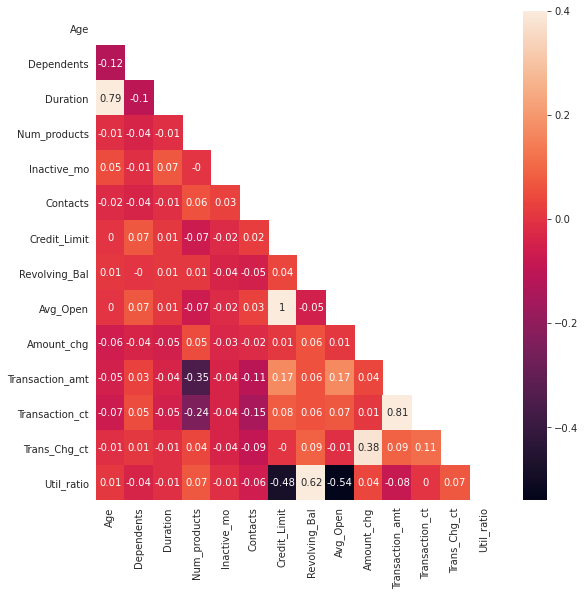

In [295]:
corr_map(['Age', 'Dependents',
       'Duration', 'Num_products', 'Inactive_mo', 'Contacts',
       'Credit_Limit', 'Revolving_Bal', 'Avg_Open', 'Amount_chg',
       'Transaction_amt', 'Transaction_ct', 'Trans_Chg_ct', 'Util_ratio']);

high correlation between some variables
-> remove Duration, Avg_Open, Transaction_Amt, Amount_chg, Util_ratio

In [296]:
# drop select variables to minimize correlation
data2.drop(['Duration','Avg_Open','Transaction_amt','Amount_chg','Util_ratio'], axis = 1, inplace=True)

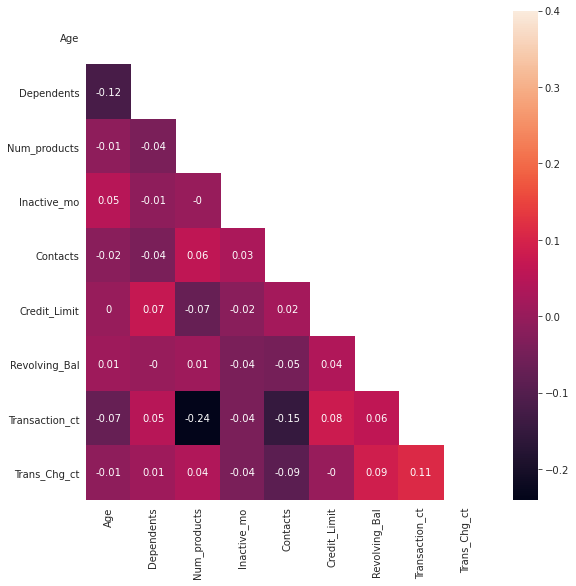

In [297]:
corr_map(['Age', 'Dependents',
        'Num_products', 'Inactive_mo', 'Contacts',
       'Credit_Limit', 'Revolving_Bal',  
        'Transaction_ct', 'Trans_Chg_ct']);
# remaining numerical variables with minimal correlation

In [83]:
# transforming categorical values to numerical
# group transformation taking a long time/ hanging -> 
#   do one by one

##### Converting to binary/ numerical

In [85]:
# getting dummies
# removing original column
# removing base variable for dummies

In [298]:
att = pd.get_dummies(data.Attrition)
data2 = pd.concat([data2, att], axis = 1)
data2.drop(['Attrition', 'Existing Customer'],axis=1, inplace=True)
data2.rename({'Attrited Customer': 'Attrition'}, axis=1, inplace=True)
data2.head(2)

,Age,Gender,Dependents,Education,Marital,Income,Card,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Transaction_ct,Trans_Chg_ct,Age_group,Util_model_pred,Credit_Limit_transf,Util_comp_pred,Util_res,Attrition
0,45,M,3,High School,Married,$70K,Blue,5,1,3,12691.0,777,42,1.625,middle,0.136049,[3.24873427815878],[0.12740487149831825],0.075049,0
1,49,F,5,Graduate,Single,$40K,Blue,6,1,2,8256.0,864,33,3.714,middle,0.193195,[3.2184676547573843],[0.18491145596096992],0.088195,0


In [299]:
gen = pd.get_dummies(data.Gender)
data2 = pd.concat([data2, gen], axis = 1)
data2.drop(['Gender','F'],axis=1, inplace=True)
data2.rename({'M':'Male'}, axis = 1,inplace=True)
data2.head(2)
# base dummy: Female

,Age,Dependents,Education,Marital,Income,Card,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Transaction_ct,Trans_Chg_ct,Age_group,Util_model_pred,Credit_Limit_transf,Util_comp_pred,Util_res,Attrition,Male
0,45,3,High School,Married,$70K,Blue,5,1,3,12691.0,777,42,1.625,middle,0.136049,[3.24873427815878],[0.12740487149831825],0.075049,0,1
1,49,5,Graduate,Single,$40K,Blue,6,1,2,8256.0,864,33,3.714,middle,0.193195,[3.2184676547573843],[0.18491145596096992],0.088195,0,0


In [300]:
ed = pd.get_dummies(data.Education)
data2 = pd.concat([data2, ed], axis = 1)
data2.drop(['Education','Uneducated'],axis=1, inplace=True)
data2.rename({'Post-Graduate':'Postgrad', 'High School': 'HS'},
            axis = 1,inplace=True)
data2.head(1)
# base dummy: Uneducated

,Age,Dependents,Marital,Income,Card,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Transaction_ct,Trans_Chg_ct,Age_group,Util_model_pred,Credit_Limit_transf,Util_comp_pred,Util_res,Attrition,Male,College,Graduate,HS,Postgrad
0,45,3,Married,$70K,Blue,5,1,3,12691.0,777,42,1.625,middle,0.136049,[3.24873427815878],[0.12740487149831825],0.075049,0,1,0,0,1,0


In [301]:
mar = pd.get_dummies(data.Marital)
data2 = pd.concat([data2, mar], axis = 1)
data2.drop(['Marital','Single'],axis=1, inplace=True)
data2.head(1)
# base dummy: Single

,Age,Dependents,Income,Card,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Transaction_ct,Trans_Chg_ct,Age_group,Util_model_pred,Credit_Limit_transf,Util_comp_pred,Util_res,Attrition,Male,College,Graduate,HS,Postgrad,Divorced,Married
0,45,3,$70K,Blue,5,1,3,12691.0,777,42,1.625,middle,0.136049,[3.24873427815878],[0.12740487149831825],0.075049,0,1,0,0,1,0,0,1


In [90]:
data.Income.value_counts()

$40K     4673
$50K     1790
$100K    1535
$70K     1402
$120K     727
Name: Income, dtype: int64

In [302]:
inc = pd.get_dummies(data.Income)
data2 = pd.concat([data2, inc], axis = 1)
data2.drop(['Income','$40K'],axis=1, inplace=True)
data2.head(1)
# base dummy: < $40K

,Age,Dependents,Card,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Transaction_ct,Trans_Chg_ct,Age_group,Util_model_pred,Credit_Limit_transf,Util_comp_pred,Util_res,Attrition,Male,College,Graduate,HS,Postgrad,Divorced,Married,$100K,$120K,$50K,$70K
0,45,3,Blue,5,1,3,12691.0,777,42,1.625,middle,0.136049,[3.24873427815878],[0.12740487149831825],0.075049,0,1,0,0,1,0,0,1,0,0,0,1


In [303]:
card = pd.get_dummies(data.Card)
data2 = pd.concat([data2, card], axis = 1)
data2.drop(['Card','Blue'],axis=1, inplace=True)
data2.head(1)
# base dummy: Blue

,Age,Dependents,Num_products,Inactive_mo,Contacts,Credit_Limit,Revolving_Bal,Transaction_ct,Trans_Chg_ct,Age_group,Util_model_pred,Credit_Limit_transf,Util_comp_pred,Util_res,Attrition,Male,College,Graduate,HS,Postgrad,Divorced,Married,$100K,$120K,$50K,$70K,Gold,Platinum,Silver
0,45,3,5,1,3,12691.0,777,42,1.625,middle,0.136049,[3.24873427815878],[0.12740487149831825],0.075049,0,1,0,0,1,0,0,1,0,0,0,1,0,0,0


In [304]:
data2 = data2.reindex(columns = 
        ['Age', 'Male', 'HS','College','Graduate','Postgrad',
        'Married','Divorced','Dependents',
         '$50K','$70K','$100K','$120K',
         'Silver','Gold','Platinum',
         'Num_products','Credit_Limit','Revolving_Bal',
         'Transaction_ct','Trans_Chg_ct','Inactive_mo','Contacts',
         'Attrition'
        ])
data2.head(2)

,Age,Male,HS,College,Graduate,Postgrad,Married,Divorced,Dependents,$50K,$70K,$100K,$120K,Silver,Gold,Platinum,Num_products,Credit_Limit,Revolving_Bal,Transaction_ct,Trans_Chg_ct,Inactive_mo,Contacts,Attrition
0,45,1,1,0,0,0,1,0,3,0,1,0,0,0,0,0,5,12691.0,777,42,1.625,1,3,0
1,49,0,0,0,1,0,0,0,5,0,0,0,0,0,0,0,6,8256.0,864,33,3.714,1,2,0


In [94]:
# data ready for regression

In [95]:
data2.describe()

,Age,Male,HS,College,Graduate,Postgrad,Married,Divorced,Dependents,$50K,$70K,$100K,$120K,Silver,Gold,Platinum,Num_products,Credit_Limit,Revolving_Bal,Transaction_ct,Trans_Chg_ct,Inactive_mo,Contacts,Attrition
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,0.470919,0.198776,0.100030,0.458872,0.095487,0.536783,0.073862,2.346203,0.176755,0.138442,0.151575,0.071788,0.054804,0.011455,0.001975,3.812580,8631.953698,1162.814061,64.858695,0.712222,2.341167,2.455317,0.160660
std,8.016814,0.499178,0.399098,0.300054,0.498330,0.293901,0.498670,0.261559,1.298908,0.381480,0.345380,0.358626,0.258150,0.227608,0.106416,0.044398,1.554408,9088.776650,814.987335,23.472570,0.238086,1.010622,1.106225,0.367235
min,26.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1438.300000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000
25%,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,3.000000,2555.000000,359.000000,45.000000,0.582000,2.000000,2.000000,0.000000
50%,46.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,4549.000000,1276.000000,67.000000,0.702000,2.000000,2.000000,0.000000
75%,52.000000,1.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,11067.500000,1784.000000,81.000000,0.818000,3.000000,3.000000,0.000000
max,73.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,34516.000000,2517.000000,139.000000,3.714000,6.000000,6.000000,1.000000


In [97]:
data2.Attrition.value_counts()
# adequate number of minority group

0    8500
1    1627
Name: Attrition, dtype: int64

##### Modelling Regression

In [307]:
# trying logit with scaler
X = data2[['Age', 'Male', 'HS', 'College', 'Graduate', 'Postgrad', 'Married',
       'Divorced', 'Dependents', '$50K', '$70K', '$100K', '$120K', 'Silver',
       'Gold', 'Platinum', 'Num_products', 'Credit_Limit', 'Revolving_Bal',
       'Transaction_ct', 'Trans_Chg_ct', 'Inactive_mo', 'Contacts' ]]
y = data2.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X = sm.add_constant(X)

scaler = MinMaxScaler()
scaler.fit_transform(X_train)
model = sm.Logit(y_train, X_train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7065
Method:                           MLE   Df Model:                           22
Date:                Sun, 28 Mar 2021   Pseudo R-squ.:                     inf
Time:                        12:47:37   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.0343      0.004      8.431      0.000       0.026       0.042
Male              -0.5206      0.164     -3.167      0.002      -0.843      -0.198
HS                 0.2828      0.151      1.868      0.062      -0.014       0.580
College            0.2968      0.175      1.691      0.091      -0.047       0.641
Graduate           0.3850      0.130      2.957      0.003       0.130       0.640
Postgrad           0.6323      0.171      3.689      0.000       0.296       0.968
Married           -0.3354      0.091     -3.692      0.000      -0.513      -0.157
Divorced           0.2083      0.167      1.246      0.213      -0.119       0.536
Dependents         0.2676      0.033      8.212      0.000       0.204       0.331
$50K              -0.0936      0.132     -0.707      0.479      -0.353       0.166
$70K               0.0843      0.207      0.408      0.684      -0.321       0.490
$100K              0.1653      0.209      0.790      0.429      -0.245       0.575
$120K              0.4878      0.240      2.034      0.042       0.018       0.958
Silver             0.6505      0.226      2.875      0.004       0.207       1.094
Gold               1.2307      0.416      2.961      0.003       0.416       2.045
Platinum           1.5353      0.834      1.840      0.066      -0.100       3.171
Num_products      -0.4089      0.029    -13.988      0.000      -0.466      -0.352
Credit_Limit    -9.84e-06   6.88e-06     -1.431      0.153   -2.33e-05    3.64e-06
Revolving_Bal     -0.0008    5.2e-05    -15.949      0.000      -0.001      -0.001
Transaction_ct    -0.0570      0.002    -24.081      0.000      -0.062      -0.052
Trans_Chg_ct      -2.1376      0.191    -11.195      0.000      -2.512      -1.763
Inactive_mo        0.5643      0.041     13.756      0.000       0.484       0.645
Contacts           0.6050      0.040     15.179      0.000       0.527       0.683
==================================================================================
"""

In [308]:
# with logit(p) = log(odds) = a + bX
# odds = p/q
# OR = exp(b)

result = pd.DataFrame({'coefficients': model.params,
                      'p-value': model.pvalues,
                      'odds-ratio': np.exp(model.params)})

# retain variables with low p
retain = result [result['p-value'] <= 0.05]
retain

,coefficients,p-value,odds-ratio
Age,0.034344,3.433231e-17,1.034940
Male,-0.520596,1.537928e-03,0.594166
Graduate,0.385008,3.108047e-03,1.469626
Postgrad,0.632309,2.249776e-04,1.881951
Married,-0.335363,2.225468e-04,0.715078
Dependents,0.267588,2.180287e-16,1.306809
$120K,0.487809,4.197388e-02,1.628744
Silver,0.650504,4.036369e-03,1.916507
Gold,1.230689,3.063011e-03,3.423587
Num_products,-0.408931,1.838913e-44,0.664360


Preliminary findings:

Liable to Attrition:

    Silver and Gold cards compared to Blue
    Education Graduate and higher compared to uneducated
    Salary more than mean $100 compared to less than $40
    Changes in transaction count
    Every inactive month increases the probability of attrition 1.7x
    Every contact effort with the bank increases the probability of attrition by almost 2x


Less liable to Attrition:

    Males compared to females
    Married compared to singles
    High use of bank products
    Every transaction leads to a 5% decrease in th e probability of attrition
    

In [100]:
retain.index

Index(['Age', 'Male', 'HS', 'College', 'Graduate', 'Postgrad', 'Married',
       'Dependents', '$120K', 'Silver', 'Gold', 'Num_products',
       'Revolving_Bal', 'Transaction_ct', 'Trans_Chg_ct', 'Inactive_mo',
       'Contacts'],
      dtype='object')

In [309]:
# trimmed variables
X = data2[['Age', 'Male', 'HS', 'Graduate', 'Postgrad', 'Married', 'Dependents',
       '$100K', '$120K', 'Silver', 'Gold', 'Num_products', 'Revolving_Bal',
       'Transaction_ct', 'Trans_Chg_ct', 'Inactive_mo', 'Contacts' ]]
y = data2.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X = sm.add_constant(X)

scaler = MinMaxScaler()
scaler.fit_transform(X_train)
model = sm.Logit(y_train, X_train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7071
Method:                           MLE   Df Model:                           16
Date:                Sun, 28 Mar 2021   Pseudo R-squ.:                     inf
Time:                        12:47:53   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Age                0.0372      0.004      9.495      0.000       0.030       0.045
Male              -0.6386      0.107     -5.974      0.000      -0.848      -0.429
HS                 0.2812      0.128      2.190      0.029       0.030       0.533
Graduate           0.2968      0.106      2.804      0.005       0.089       0.504
Postgrad           0.5070      0.153      3.309      0.001       0.207       0.807
Married           -0.2726      0.085     -3.202      0.001      -0.439      -0.106
Dependents         0.2554      0.032      7.996      0.000       0.193       0.318
$100K              0.2283      0.141      1.620      0.105      -0.048       0.504
$120K              0.3174      0.175      1.818      0.069      -0.025       0.660
Silver             0.4218      0.197      2.146      0.032       0.037       0.807
Gold               0.8136      0.388      2.099      0.036       0.054       1.573
Num_products      -0.3909      0.029    -13.704      0.000      -0.447      -0.335
Revolving_Bal     -0.0008   5.12e-05    -16.032      0.000      -0.001      -0.001
Transaction_ct    -0.0576      0.002    -24.773      0.000      -0.062      -0.053
Trans_Chg_ct      -2.0681      0.186    -11.145      0.000      -2.432      -1.704
Inactive_mo        0.5226      0.040     13.118      0.000       0.445       0.601
Contacts           0.6066      0.039     15.515      0.000       0.530       0.683
==================================================================================
"""

In [102]:
# further trim off: HS, Revolving_Bal, Age, Contacts, Transaction_ct

In [310]:
# trimming
X = data2[[ 'Male', 'HS', 'Graduate', 'Postgrad', 'Married', 'Dependents',
       '$100K', '$120K', 'Silver', 'Gold', 'Num_products',
        'Trans_Chg_ct', 'Inactive_mo' ]]
y = data2.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X = sm.add_constant(X)

scaler = MinMaxScaler()
scaler.fit_transform(X_train)
model = sm.Logit(y_train, X_train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7075
Method:                           MLE   Df Model:                           12
Date:                Sun, 28 Mar 2021   Pseudo R-squ.:                     inf
Time:                        12:48:03   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Male            -0.3478      0.089     -3.902      0.000      -0.523      -0.173
HS               0.2291      0.107      2.142      0.032       0.019       0.439
Graduate         0.2747      0.087      3.141      0.002       0.103       0.446
Postgrad         0.5235      0.126      4.171      0.000       0.278       0.770
Married         -0.1161      0.070     -1.654      0.098      -0.254       0.022
Dependents       0.1411      0.026      5.369      0.000       0.090       0.193
$100K            0.3074      0.118      2.601      0.009       0.076       0.539
$120K            0.3306      0.149      2.223      0.026       0.039       0.622
Silver          -0.0088      0.156     -0.056      0.955      -0.315       0.298
Gold             0.2491      0.303      0.823      0.411      -0.344       0.842
Num_products    -0.1930      0.021     -9.205      0.000      -0.234      -0.152
Trans_Chg_ct    -4.1482      0.164    -25.344      0.000      -4.469      -3.827
Inactive_mo      0.5155      0.032     16.314      0.000       0.454       0.577
================================================================================
"""

In [104]:
# remove married, 100K, silver, gold

In [318]:
# trimming
X = data2[[ 'Male', 'HS', 'Graduate', 'Postgrad', 'Dependents',
        '$120K',  'Num_products',
        'Trans_Chg_ct', 'Inactive_mo' ]]
y = data2.Attrition

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

X = sm.add_constant(X)

scaler = MinMaxScaler()
scaler.fit_transform(X_train)
model = sm.Logit(y_train, X_train).fit()

model.summary()

Optimization terminated successfully.
         Current function value: inf
         Iterations 7


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              Attrition   No. Observations:                 7088
Model:                          Logit   Df Residuals:                     7079
Method:                           MLE   Df Model:                            8
Date:                Sun, 28 Mar 2021   Pseudo R-squ.:                     inf
Time:                        13:16:17   Log-Likelihood:                   -inf
converged:                       True   LL-Null:                        0.0000
Covariance Type:            nonrobust   LLR p-value:                     1.000
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Male            -0.1775      0.074     -2.405      0.016      -0.322      -0.033
HS               0.2071      0.105      1.965      0.049       0.001       0.414
Graduate         0.1815      0.087      2.077      0.038       0.010       0.353
Postgrad         0.4260      0.126      3.390      0.001       0.180       0.672
Dependents       0.1376      0.026      5.299      0.000       0.087       0.189
$120K            0.0606      0.143      0.424      0.672      -0.220       0.341
Num_products    -0.2100      0.021     -9.954      0.000      -0.251      -0.169
Trans_Chg_ct    -4.2138      0.164    -25.710      0.000      -4.535      -3.893
Inactive_mo      0.5494      0.031     17.498      0.000       0.488       0.611
================================================================================
"""

In [312]:
result = pd.DataFrame({'coefficients': model.params,
                      'p-value': model.pvalues,
                      'odds-raio': np.exp(model.params)})

retain = result [result['p-value'] <= 0.05]
retain

,coefficients,p-value,odds-raio
Male,-0.170529,2.097132e-02,0.843218
Graduate,0.220173,1.115472e-02,1.246292
Postgrad,0.430616,6.145623e-04,1.538205
Dependents,0.117913,4.516318e-06,1.125146
Num_products,-0.210258,7.400310e-24,0.810375
Trans_Chg_ct,-4.095283,5.865364e-142,0.016651
Inactive_mo,0.532291,1.728250e-66,1.702829


Interim Findings:

Liable to Attrition:

    Higher education 
    Increasing dependents
    Inactivity

Less liable to Attrition:

    Males compared to females
    Increasing number of bank products used
    Every transaction done

In [107]:
#@ option: use this model or trim further
# trim down those with lowest coeff, higher p: dependents, num_products

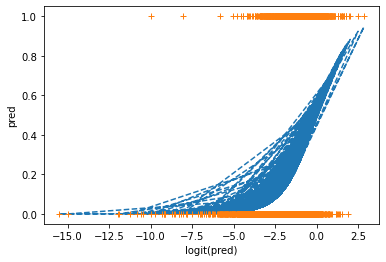

In [327]:
# if use option of using this model:
# gathering predicted data
pred = model.predict(X_train)
data2.loc[:,'pred']= pred

plt.plot(logit(data2.pred), data2.pred,'--')
plt.plot(logit(data2.pred), data2.Attrition, '+')
plt.xlabel('logit(pred)')
plt.ylabel('pred');

array([[5883.,   66.],
       [ 963.,  176.]])

tn = 5883.0
fp =  66.0
fn =  963.0
tp = 176.0
accuracy = 0.85
correlation coefficient = 0.01
precision =  0.73
recall =  0.15
Perecentage Area under the curve =  78.07


array([[5883.,   66.],
       [ 963.,  176.]])

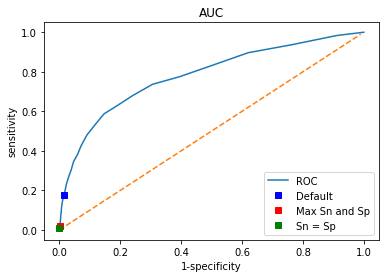

In [371]:
# deriving estimates, metrics
display(model.pred_table())
tn, fp, fn, tp = model.pred_table().flatten()
print('tn =', tn)
print('fp = ', fp)
print ('fn = ', fn)
print('tp =', tp)

accuracy = (tp+tn)/ np.sum(model.pred_table())
print('accuracy =', accuracy.round(2))
mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn*fn))
print('correlation coefficient =',mcc.round(2))
precision = tp / (tp+fp)
print('precision = ',precision.round(2))
recall = tp / (tp+fn)
print('recall = ',recall.round(2))

# getting roc
thr = np.arange(0,1,0.025)
sensitivity = []
specificity = []
accuracy = []
corrcoeff = []

for x in thr:
    conf_mat = model.pred_table(threshold = x)
    tn, fp, fn, tp = conf_mat.flatten()
    sensit = (1*tp) / (tp+fn)
    specific = (1*tn) / (tn+fp)
    accur = (tp+tn) / np.sum(conf_mat)
    mcc = (tp*tn - fp*fn) / np.sqrt((tp+fp) * (tp+fn) * (tn+fp) * (tn*fn))
    sensitivity.append(sensit)
    specificity.append(specific)
    accuracy.append(accur)
    corrcoeff.append(mcc)

curve = pd.DataFrame({'thr':thr,
                     'sensitivity':sensitivity,
                     'specificity':specificity,
                     '_specificity':[1 - y for y in specificity],
                     'accuracy':accuracy,
                     'correlation_coeff':corrcoeff})
curve = curve.sort_values(by= '_specificity')

plt.plot(curve._specificity, curve.sensitivity, label = 'ROC')
plt.plot(np.arange(0,1,0.01),
        np.arange(0,1,0.01), '--')
plt.legend()
plt.xlabel('1-specificity')
plt.ylabel('sensitivity')
plt.title('AUC');

auc = np.trapz( y = curve.sensitivity, x = curve._specificity)
print('Perecentage Area under the curve = ', round((auc*100),2))

default_thr = np.where(curve.thr == 0.5)[0][0]
plt.plot(curve._specificity[default_thr], 
         curve.sensitivity[default_thr],
        's',color = 'blue',label = 'Default');
youdensj = np.argmax(curve.sensitivity + curve.specificity)
plt.plot(curve._specificity[youdensj], 
         curve.sensitivity[youdensj],
        's', color = 'red', label = 'Max Sn and Sp')
balance = np.argmin(np.abs(curve.sensitivity - curve.specificity))
plt.plot(curve._specificity[balance], 
        curve.sensitivity[balance],
        's',color = 'green',label = 'Sn = Sp')
plt.legend();

Results:  The present model has a good accuracy rate of 0.85, a good AUC of 0.78.  There is increased odds for attrition for graduates, post-graduates, increasing number of dependents and increasing length of inactivity.  There is decreased odds for attrition for males, higher use of bank products, and increased transactions done.

Interpretation:  Attrition outcome may be predicted gender, level of education, number of dependents, number of products used, transaction count changes and account inactivity. 

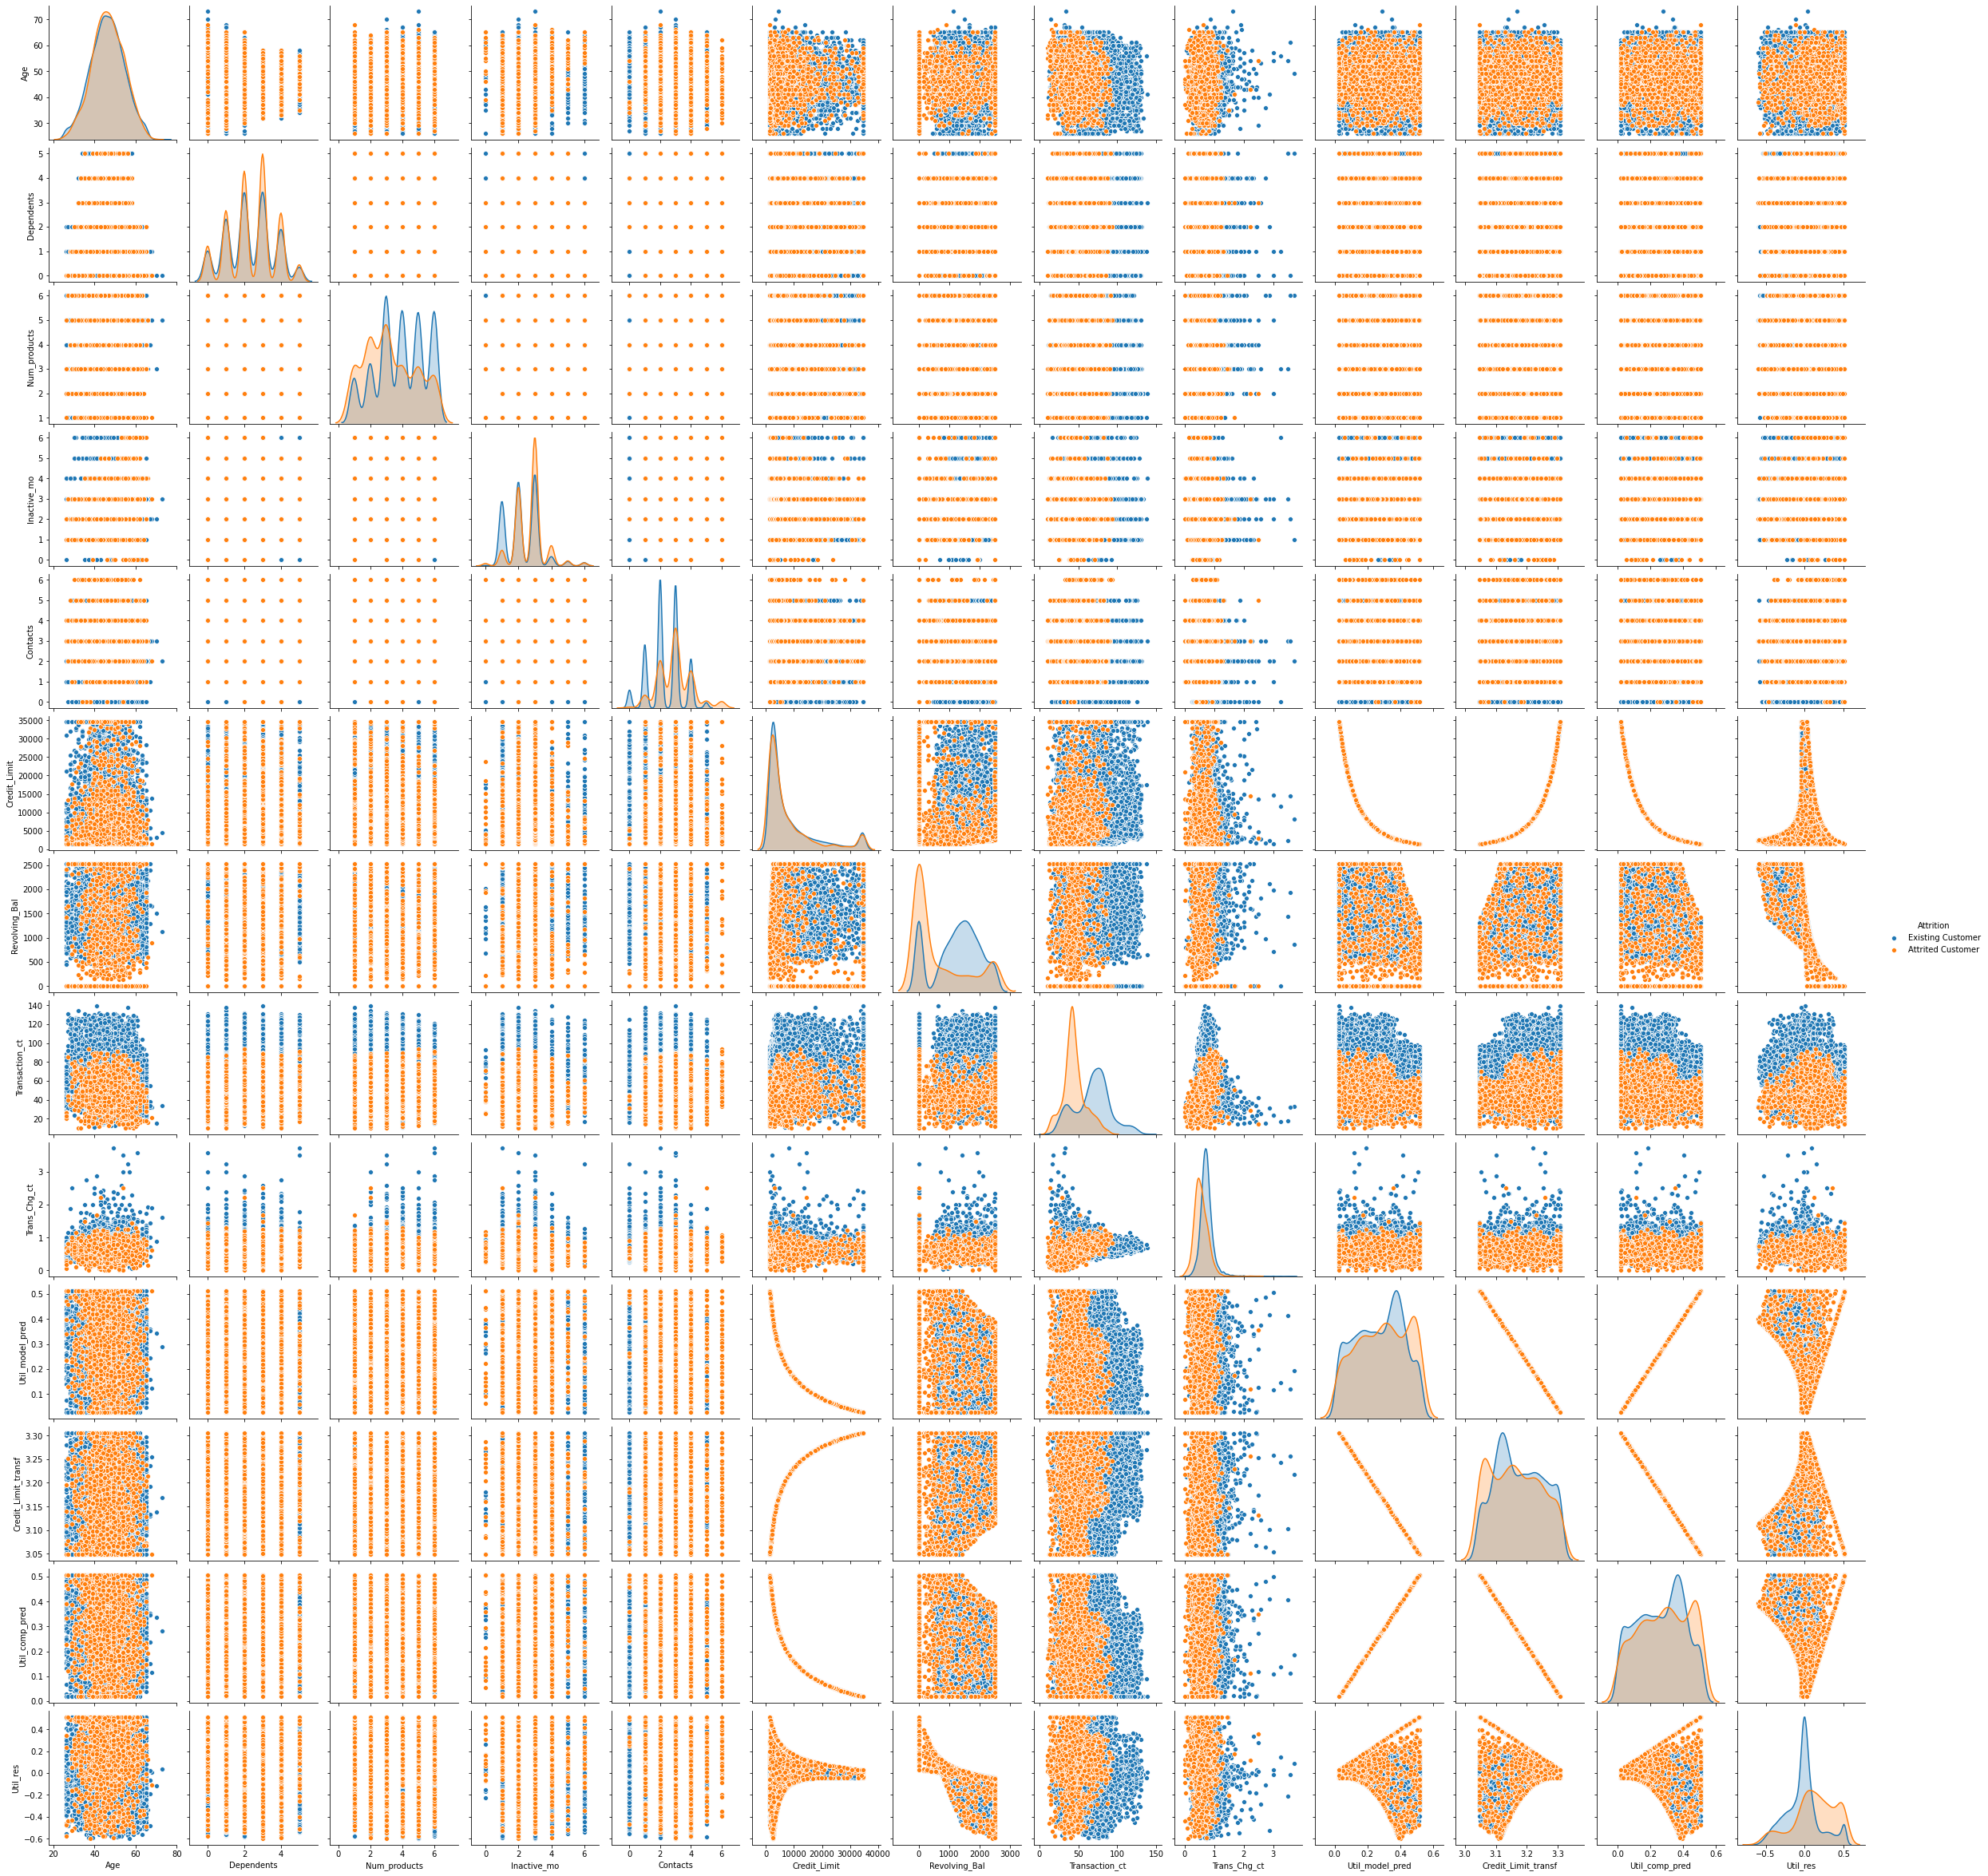

In [116]:
sns.pairplot(data, hue = 'Attrition');
# used to verify findings above

### Summary of Findings and possible Recommendations:

#### Customer profile:
    - There is a significantly higher proportion of females among the customers.
    - High-income card owners are older, with a mean age of 47.6 +/- 6.7 (CI 43-53).
    - Low-income is independent of marital status and educational level

-->  Provide bank with background on either increasing the satisfaction by offering female-oriented or older-age oriented rewards, OR by an increased effort to enhance recruitment of males and other-income groups
    
#### Credit Card profile:
    -  Blue cards are the most common, followed by Silver, Gold and Platinum.
    -  The card type is independent of age and education
    -  Blue cards are popular with females, married customers, and the low-income group
    -  Silver and Gold cards are popular with males
    
-->  Bank can enhance recruitment of credit card owners by offering activities and rewards targeted to females, married people, and offering savings-oriented plans for the low-income group

--> Bank can offer exclusive rewards targeted towards the male population
    
#### Credit Utilization profile
    -  Females make more frequent transactions.
    -  Males make more expensive transactions.
    -  Platinum card holders make more frequent transactions.
    -  Credit limits up to around 4 thousand dollars are well utilized, with a sharp decline in utilization beyond 4 thousand.
    
-->  Bank can tailor the benefits of credit card charges (% per use and % of amount payable) to a target population

-->  Bank can gauge the liquidity of their assets by assigning on average 4 thousand credit units per card holder

-->  Banks can offer lower fees for credit use above 4 thousand to increase utilization
    
#### Attrition prediction
    -  Attrition may be predicted by gender, level of education, number of dependents, number of products used, transaction count changes and account inactivity. 
    
-->  Banks can do a qualification check that includes the above parameters to ascertain good customer retention and minimize churning